In [1]:
colab = True

if colab:
  from google.colab import drive
  drive.mount('/content/drive/')

  import sys
  sys.path.append('/content/drive/My\ Drive/dubuce/lab4/')
  %cd /content/drive/My\ Drive/dubuce/lab4/


Mounted at /content/drive/
/content/drive/My Drive/dubuce/lab4


#1. zadatak: Učitavanje podataka (10%)

In [ ]:
from torch.utils.data import Dataset
from collections import defaultdict
from random import choice
import torchvision
import torch


class MNISTMetricDataset(Dataset):
  def __init__(self, root="/tmp/mnist/", split='train', remove_class=None):
    super().__init__()
    assert split in ['train', 'test', 'traineval']
    self.root = root
    self.split = split
    mnist_ds = torchvision.datasets.MNIST(self.root, train='train' in split, download=True)
    self.images, self.targets = mnist_ds.data.float() / 255., mnist_ds.targets # X, y
    self.classes = list(range(10)) # 10 znamenki
    #3.e)
    self.remove_class = remove_class
    if remove_class is not None:
      # Filter out images with target class equal to remove_class
      # YOUR CODE HERE
      mask = self.targets != remove_class
      self.images = self.images[mask]
      self.targets = self.targets[mask]

    self.target2indices = defaultdict(list)
    for i in range(len(self.images)):
        self.target2indices[self.targets[i].item()] += [i] # klasi C dodajemo indeks i-tog primjer u listu indeksa


  def _sample_negative(self, index):
    """
    vracamo bilokoji indeks primjera koji pripada bilokojem razredu razlicitom od sidra
    """
    # YOUR CODE HERE
    y = self.targets[index].item()
    y_different = y
    while y_different == y or y_different == self.remove_class:
      y_different = choice(self.classes)

    Nc = len(self.target2indices[y_different])

    return self.target2indices[y_different][np.random.randint(0, high=Nc)]


  def _sample_positive(self, index):
    """
    vracamo bilokoji indeks primjera koji pripada istom razredu kao sidro
    """
    # YOUR CODE HERE
    y = self.targets[index].item()
    Nc = len(self.target2indices[y])

    return self.target2indices[y][np.random.randint(0, high=Nc)]


  def __getitem__(self, index):
    anchor = self.images[index].unsqueeze(0) # sidro
    target_id = self.targets[index].item() # labela sidra
    if self.split in ['traineval', 'val', 'test']:
      return anchor, target_id
    else:
      positive = self._sample_positive(index)
      negative = self._sample_negative(index)
      positive = self.images[positive]
      negative = self.images[negative]
      return anchor, positive.unsqueeze(0), negative.unsqueeze(0), target_id


  def __len__(self):
    return len(self.images)


#2. zadatak: Definicija modela za metričko ugrađivanje (40%)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class _BNReluConv(nn.Sequential):
  # BatchNorm -> ReLU -> Conv : cca: 90% test acc
  # BatchNorm -> Conv -> ReLU : cca: 94% test acc
  # Conv -> Batchnorm -> ReLU : cca: 92.67% test acc
  # Conv -> ReLU -> Batchnorm : cca: 96.03% test acc --> najbolji test acc
  def __init__(self, num_maps_in, num_maps_out, k=3, bias=True):
    super(_BNReluConv, self).__init__()
    # YOUR CODE HERE
    self.append(nn.Conv2d(num_maps_in, num_maps_out, kernel_size=k, padding=2, bias=bias))
    self.append(nn.ReLU())
    self.append(nn.BatchNorm2d(num_maps_out))



class SimpleMetricEmbedding(nn.Module):
  def __init__(self, input_channels, emb_size=32, name='SimpleMetricEmbedding1'):
    super().__init__()
    self.emb_size = emb_size
    self.name = name
    # YOUR CODE HERE
    self.bn_relu_conv1 = _BNReluConv(input_channels, emb_size)
    #self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=0) # ?
    self.bn_relu_conv2 = _BNReluConv(emb_size, emb_size)
    #self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=0) # ?
    self.bn_relu_conv3 = _BNReluConv(emb_size, emb_size)
    self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=0)
    self.global_avg_pool = nn.AdaptiveAvgPool2d(output_size=1) # izlaz: (N, C, 1, 1)


  def get_features(self, img):
    # Returns tensor with dimensions BATCH_SIZE, EMB_SIZE
    # YOUR CODE HERE
    x = self.bn_relu_conv1(img)
    #x = self.maxpool1(x)
    x = self.bn_relu_conv2(x)
    #x = self.maxpool2(x)
    x = self.bn_relu_conv3(x)
    x = self.maxpool3(x)
    x = self.global_avg_pool(x)

    return torch.squeeze(x, dim=(2, 3))


  def loss(self, anchor, positive, negative):
    a_x = self.get_features(anchor)
    p_x = self.get_features(positive)
    n_x = self.get_features(negative)
    # YOUR CODE HERE
    d_ap = torch.norm(a_x - p_x, dim=1)
    d_an = torch.norm(a_x - n_x, dim=1)
    zeros = torch.zeros(d_ap.shape, device=device)
    margin = torch.ones(d_ap.shape, device=device) # default margin
    loss = torch.sum(torch.maximum(zeros, d_ap - d_an + margin))

    return loss


#3. zadatak: Učenje i vrednovanje (40%)

##a) Analiza modula utils.py

In [ ]:
import numpy as np
import torch
from collections import defaultdict
import os
PRINT_LOSS_N = 100


def train(model, optimizer, loader, device='cuda'):
  losses = []
  model.train()
  print("Treniranje modela:")
  for i, data in enumerate(loader):
    anchor, positive, negative, _ = data
    optimizer.zero_grad()
    loss = model.loss(anchor.to(device), positive.to(device), negative.to(device))
    loss.backward()
    optimizer.step()
    losses.append(loss.cpu().item())
    if i % PRINT_LOSS_N == 0:
      print(f"Iter: {i}, Mean Loss: {np.mean(losses):.3f}")
  # 3.d) Pohranjivanje modela
  print("Spremanje parametara modela:")
  torch.save(model.state_dict(), f'{model.name}.pth')

  return np.mean(losses)


def compute_representations(model, loader, identities_count, emb_size=32, device='cuda'):
  model.eval()
  representations = defaultdict(list)
  for i, data in enumerate(loader):
    anchor, id = data[0], data[-1] # anchor, target_id
    with torch.no_grad():
      repr = model.get_features(anchor.to(device)) # reprezentacija = model(anchor)
      repr = repr.view(-1, emb_size) # reshapeamo
    for i in range(id.shape[0]):
      representations[id[i].item()].append(repr[i]) # spremamo sve reprezentacije iz batcha
  averaged_repr = torch.zeros(identities_count, emb_size).to(device)
  for k, items in representations.items():
    r = torch.cat([v.unsqueeze(0) for v in items], 0).mean(0) # racuna mean vrijednost reprezentacije svih primjera klase
    averaged_repr[k] = r / torch.linalg.vector_norm(r) #
  return averaged_repr


def make_predictions(representations, r):
  return ((representations - r)**2).sum(1) # predictions based on L2 distance


def evaluate(model, repr, loader, device):
  model.eval()
  total = 0
  correct = 0
  for i, data in enumerate(loader):
    anchor, id = data
    id = id.to(device)
    with torch.no_grad():
      r = model.get_features(anchor.to(device))
      r = r / torch.linalg.vector_norm(r)
    pred = make_predictions(repr, r)
    top1 = pred.min(0)[1]
    correct += top1.eq(id).sum().item()
    total += 1
  return correct/total

##b) Klasifikacija na temelju metričkog ugrađivanja

In [ ]:
import time
import torch.optim
#from dataset import MNISTMetricDataset
from torch.utils.data import DataLoader
#from model import SimpleMetricEmbedding
#from utils import train, evaluate, compute_representations

EVAL_ON_TEST = True
EVAL_ON_TRAIN = False


if __name__ == '__main__':
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print(f"= Using device {device}")

  # CHANGE ACCORDING TO YOUR PREFERENCE
  mnist_download_root = "./mnist/"
  ds_train = MNISTMetricDataset(mnist_download_root, split='train')
  ds_test = MNISTMetricDataset(mnist_download_root, split='test')
  ds_traineval = MNISTMetricDataset(mnist_download_root, split='traineval')

  num_classes = 10

  print(f"> Loaded {len(ds_train)} training images!")
  print(f"> Loaded {len(ds_test)} validation images!")

  train_loader = DataLoader(
      ds_train,
      batch_size=64,
      shuffle=True,
      pin_memory=True,
      #num_workers=4,
      drop_last=True
  )

  test_loader = DataLoader(
      ds_test,
      batch_size=1,
      shuffle=False,
      pin_memory=True
      #num_workers=1
  )

  traineval_loader = DataLoader(
      ds_traineval,
      batch_size=1,
      shuffle=False,
      pin_memory=True
      #num_workers=1
  )

  emb_size = 32
  model = SimpleMetricEmbedding(1, emb_size).to(device)
  optimizer = torch.optim.Adam(
      model.parameters(),
      lr=1e-3
  )

  epochs = 3
  for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    t0 = time.time_ns()
    train_loss = train(model, optimizer, train_loader, device)
    print(f"Mean Loss in Epoch {epoch}: {train_loss:.3f}")
    if EVAL_ON_TEST or EVAL_ON_TRAIN:
      print("Computing mean representations for evaluation...")
      representations = compute_representations(model, train_loader, num_classes, emb_size, device)
    if EVAL_ON_TRAIN:
      print("Evaluating on training set...")
      acc1 = evaluate(model, representations, traineval_loader, device)
      print(f"Epoch {epoch}: Train Top1 Acc: {round(acc1 * 100, 2)}%")
    if EVAL_ON_TEST:
      print("Evaluating on test set...")
      acc1 = evaluate(model, representations, test_loader, device)
      print(f"Epoch {epoch}: Test Accuracy: {acc1 * 100:.2f}%")
    t1 = time.time_ns()
    print(f"Epoch time (sec): {(t1-t0)/10**9:.1f}")



= Using device cuda
> Loaded 60000 training images!
> Loaded 10000 validation images!
Epoch: 0
Treniranje modela:
Iter: 0, Mean Loss: 42.933
Iter: 100, Mean Loss: 29.361
Iter: 200, Mean Loss: 23.684
Iter: 300, Mean Loss: 20.072
Iter: 400, Mean Loss: 17.876
Iter: 500, Mean Loss: 16.324
Iter: 600, Mean Loss: 15.096
Iter: 700, Mean Loss: 14.173
Iter: 800, Mean Loss: 13.395
Iter: 900, Mean Loss: 12.701
Spremanje parametara modela:
Mean Loss in Epoch 0: 12.479
Computing mean representations for evaluation...
Evaluating on test set...
Epoch 0: Test Accuracy: 93.58%
Epoch time (sec): 41.7
Epoch: 1
Treniranje modela:
Iter: 0, Mean Loss: 6.360
Iter: 100, Mean Loss: 6.554
Iter: 200, Mean Loss: 6.777
Iter: 300, Mean Loss: 6.610
Iter: 400, Mean Loss: 6.418
Iter: 500, Mean Loss: 6.280
Iter: 600, Mean Loss: 6.143
Iter: 700, Mean Loss: 6.044
Iter: 800, Mean Loss: 5.967
Iter: 900, Mean Loss: 5.849
Spremanje parametara modela:
Mean Loss in Epoch 1: 5.810
Computing mean representations for evaluation...

##d) Pohranjivanje parametara modela

##c) Klasifikacija na temelju udaljenosti u prostoru slike

In [ ]:
class IdentityModel(nn.Module):
    def __init__(self):
        super(IdentityModel, self).__init__()

    def get_features(self, img):
        # YOUR CODE HERE
        feats = img.reshape(img.shape[0], -1)
        return feats


In [ ]:
import time
import torch.optim
#from dataset import MNISTMetricDataset
from torch.utils.data import DataLoader
#from model import SimpleMetricEmbedding
#from utils import train, evaluate, compute_representations

EVAL_ON_TEST = True
EVAL_ON_TRAIN = False


if __name__ == '__main__':
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print(f"= Using device {device}")

  # CHANGE ACCORDING TO YOUR PREFERENCE
  mnist_download_root = "./mnist/"
  ds_train = MNISTMetricDataset(mnist_download_root, split='train')
  ds_test = MNISTMetricDataset(mnist_download_root, split='test')
  ds_traineval = MNISTMetricDataset(mnist_download_root, split='traineval')

  num_classes = 10

  print(f"> Loaded {len(ds_train)} training images!")
  print(f"> Loaded {len(ds_test)} validation images!")

  train_loader = DataLoader(
      ds_train,
      batch_size=64,
      shuffle=True,
      pin_memory=True,
      #num_workers=4,
      drop_last=True
  )

  test_loader = DataLoader(
      ds_test,
      batch_size=1,
      shuffle=False,
      pin_memory=True
      #num_workers=1
  )

  traineval_loader = DataLoader(
      ds_traineval,
      batch_size=1,
      shuffle=False,
      pin_memory=True
      #num_workers=1
  )

  #emb_size = 28*28 # promijenjen emb size
  model = IdentityModel().to(device)
  # model ne treniramo
  #optimizer = torch.optim.Adam(
  #    model.parameters(),
  #    lr=1e-3
  #)

  epochs = 3
  for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    t0 = time.time_ns()
    #train_loss = train(model, optimizer, train_loader, device)
    #print(f"Mean Loss in Epoch {epoch}: {train_loss:.3f}")
    if EVAL_ON_TEST or EVAL_ON_TRAIN:
      print("Computing mean representations for evaluation...")
      representations = compute_representations(model, train_loader, num_classes, 28*28, device)
    if EVAL_ON_TRAIN:
      print("Evaluating on training set...")
      acc1 = evaluate(model, representations, traineval_loader, device)
      print(f"Epoch {epoch}: Train Top1 Acc: {round(acc1 * 100, 2)}%")
    if EVAL_ON_TEST:
      print("Evaluating on test set...")
      acc1 = evaluate(model, representations, test_loader, device)
      print(f"Epoch {epoch}: Test Accuracy: {acc1 * 100:.2f}%")
    t1 = time.time_ns()
    print(f"Epoch time (sec): {(t1-t0)/10**9:.1f}")

= Using device cuda
> Loaded 60000 training images!
> Loaded 10000 validation images!
Epoch: 0
Computing mean representations for evaluation...
Evaluating on test set...
Epoch 0: Test Accuracy: 82.16%
Epoch time (sec): 7.0
Epoch: 1
Computing mean representations for evaluation...
Evaluating on test set...
Epoch 1: Test Accuracy: 82.15%
Epoch time (sec): 7.8
Epoch: 2
Computing mean representations for evaluation...
Evaluating on test set...
Epoch 2: Test Accuracy: 82.16%
Epoch time (sec): 7.5


##e) Klasifikacija neviđenih razreda

In [ ]:
import time
import torch.optim
#from dataset import MNISTMetricDataset
from torch.utils.data import DataLoader
#from model import SimpleMetricEmbedding
#from utils import train, evaluate, compute_representations

EVAL_ON_TEST = True
EVAL_ON_TRAIN = False


if __name__ == '__main__':
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print(f"= Using device {device}")

  # CHANGE ACCORDING TO YOUR PREFERENCE
  mnist_download_root = "./mnist/"
  ds_train_ignore_0 = MNISTMetricDataset(mnist_download_root, split='train', remove_class=0)
  ds_train = MNISTMetricDataset(mnist_download_root, split='train')
  ds_test = MNISTMetricDataset(mnist_download_root, split='test')
  ds_traineval = MNISTMetricDataset(mnist_download_root, split='traineval')

  num_classes = 10

  print(f"> Loaded {len(ds_train)} training images!")
  print(f"> Loaded {len(ds_test)} validation images!")

  train_loader_ignore_0 = DataLoader(
      ds_train_ignore_0,
      batch_size=64,
      shuffle=True,
      pin_memory=True,
      #num_workers=4,
      drop_last=True
  )

  train_loader = DataLoader(
      ds_train,
      batch_size=64,
      shuffle=True,
      pin_memory=True,
      #num_workers=4,
      drop_last=True
  )

  test_loader = DataLoader(
      ds_test,
      batch_size=1,
      shuffle=False,
      pin_memory=True
      #num_workers=1
  )

  traineval_loader = DataLoader(
      ds_traineval,
      batch_size=1,
      shuffle=False,
      pin_memory=True
      #num_workers=1
  )

  emb_size = 32
  model_3 = SimpleMetricEmbedding(1, emb_size, 'SimpleMetricEmbedding3').to(device)
  optimizer = torch.optim.Adam(
      model_3.parameters(),
      lr=1e-3
  )

  epochs = 3
  for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    t0 = time.time_ns()
    train_loss = train(model_3, optimizer, train_loader_ignore_0, device)
    print(f"Mean Loss in Epoch {epoch}: {train_loss:.3f}")
    if EVAL_ON_TEST or EVAL_ON_TRAIN:
      print("Computing mean representations for evaluation...")
      representations = compute_representations(model_3, train_loader, num_classes, emb_size, device)
    if EVAL_ON_TRAIN:
      print("Evaluating on training set...")
      acc1 = evaluate(model_3, representations, traineval_loader, device)
      print(f"Epoch {epoch}: Train Top1 Acc: {round(acc1 * 100, 2)}%")
    if EVAL_ON_TEST:
      print("Evaluating on test set...")
      acc1 = evaluate(model_3, representations, test_loader, device)
      print(f"Epoch {epoch}: Test Accuracy: {acc1 * 100:.2f}%")
    t1 = time.time_ns()
    print(f"Epoch time (sec): {(t1-t0)/10**9:.1f}")



= Using device cuda
> Loaded 60000 training images!
> Loaded 10000 validation images!
Epoch: 0
Treniranje modela:
Iter: 0, Mean Loss: 46.104
Iter: 100, Mean Loss: 27.491
Iter: 200, Mean Loss: 22.289
Iter: 300, Mean Loss: 19.058
Iter: 400, Mean Loss: 17.149
Iter: 500, Mean Loss: 15.643
Iter: 600, Mean Loss: 14.507
Iter: 700, Mean Loss: 13.578
Iter: 800, Mean Loss: 12.849
Spremanje parametara modela:
Mean Loss in Epoch 0: 12.567
Computing mean representations for evaluation...
Evaluating on test set...
Epoch 0: Test Accuracy: 91.76%
Epoch time (sec): 38.1
Epoch: 1
Treniranje modela:
Iter: 0, Mean Loss: 8.046
Iter: 100, Mean Loss: 6.982
Iter: 200, Mean Loss: 6.897
Iter: 300, Mean Loss: 6.713
Iter: 400, Mean Loss: 6.446
Iter: 500, Mean Loss: 6.295
Iter: 600, Mean Loss: 6.148
Iter: 700, Mean Loss: 6.057
Iter: 800, Mean Loss: 5.985
Spremanje parametara modela:
Mean Loss in Epoch 1: 5.937
Computing mean representations for evaluation...
Evaluating on test set...
Epoch 1: Test Accuracy: 93.75%

#4. zadatak: Vizualizacija podataka (10%)

= Using device cuda
Hasn't seen number 0 during train time
Fitting PCA directly from images...


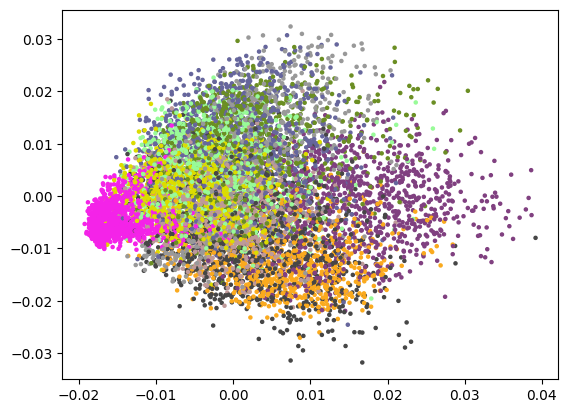

Fitting PCA from feature representation


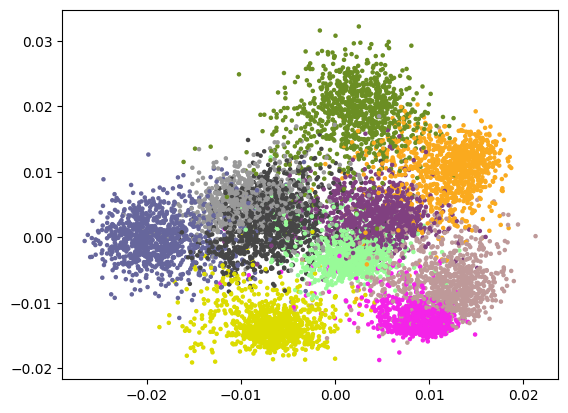

Has seen all numbers during train time
Fitting PCA directly from images...


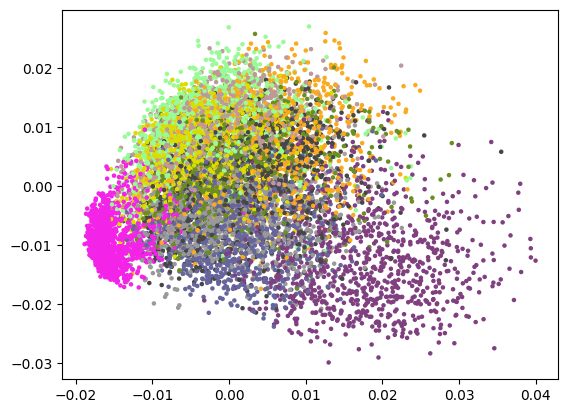

Fitting PCA from feature representation


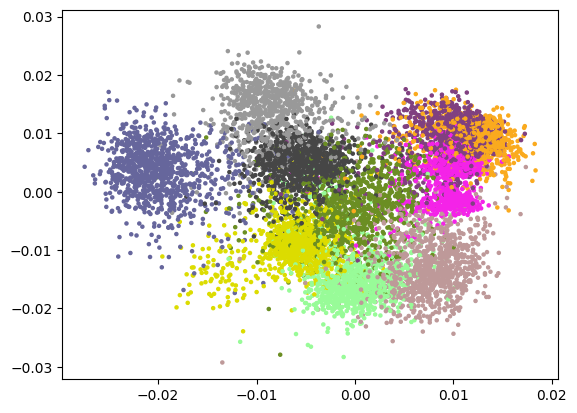

In [ ]:
import numpy as np
import torch

#from dataset import MNISTMetricDataset
#from model import SimpleMetricEmbedding
from matplotlib import pyplot as plt


def get_colormap():
    # Cityscapes colormap for first 10 classes
    colormap = np.zeros((10, 3), dtype=np.uint8)
    colormap[0] = [128, 64, 128]
    colormap[1] = [244, 35, 232]
    colormap[2] = [70, 70, 70]
    colormap[3] = [102, 102, 156]
    colormap[4] = [190, 153, 153]
    colormap[5] = [153, 153, 153]
    colormap[6] = [250, 170, 30]
    colormap[7] = [220, 220, 0]
    colormap[8] = [107, 142, 35]
    colormap[9] = [152, 251, 152]
    return colormap


if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"= Using device {device}")
    emb_size = 32
    model = SimpleMetricEmbedding(1, emb_size).to(device)
    # YOUR CODE HERE
    # LOAD TRAINED PARAMS

    # nije vidio slike sa znamenkom 0.
    model.load_state_dict(torch.load("SimpleMetricEmbedding3.pth"))
    colormap = get_colormap()
    mnist_download_root = "./mnist/"
    ds_test = MNISTMetricDataset(mnist_download_root, split='test')
    X = ds_test.images
    Y = ds_test.targets
    print("Hasn't seen number 0 during train time")
    print("Fitting PCA directly from images...")
    test_img_rep2d = torch.pca_lowrank(ds_test.images.view(-1, 28 * 28), 2)[0]
    plt.scatter(test_img_rep2d[:, 0], test_img_rep2d[:, 1], color=colormap[Y[:]] / 255., s=5)
    plt.show()
    plt.figure()

    print("Fitting PCA from feature representation")
    with torch.no_grad():
        model.eval()
        test_rep = model.get_features(X.unsqueeze(1).to(device))
        test_rep2d = torch.pca_lowrank(test_rep, 2)[0].to(device)
        plt.scatter(test_rep2d[:, 0].cpu(), test_rep2d[:, 1].cpu(), color=colormap[Y[:]] / 255., s=5)
        plt.show()

    # učen sa svim znamenkama
    model.load_state_dict(torch.load("SimpleMetricEmbedding1.pth"))

    print("Has seen all numbers during train time")
    print("Fitting PCA directly from images...")
    test_img_rep2d = torch.pca_lowrank(ds_test.images.view(-1, 28 * 28), 2)[0]
    plt.scatter(test_img_rep2d[:, 0], test_img_rep2d[:, 1], color=colormap[Y[:]] / 255., s=5)
    plt.show()
    plt.figure()

    print("Fitting PCA from feature representation")
    with torch.no_grad():
        model.eval()
        test_rep = model.get_features(X.unsqueeze(1).to(device))
        test_rep2d = torch.pca_lowrank(test_rep, 2)[0].to(device)
        plt.scatter(test_rep2d[:, 0].cpu(), test_rep2d[:, 1].cpu(), color=colormap[Y[:]] / 255., s=5)
        plt.show()
